## Домашнее задание
- Выберите ряд и постройте его модель ARIMA/GARCH.
- Не обязательное дз. Попробуйте спрогнозировать график классическим ML

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from statsmodels.tsa.stattools import adfuller

Выбираем один из временных рядов

In [2]:
data = pd.read_csv("weekly-closings-of-the-dowjones-.csv")
series = data['Close']
series_test = series[:-30]

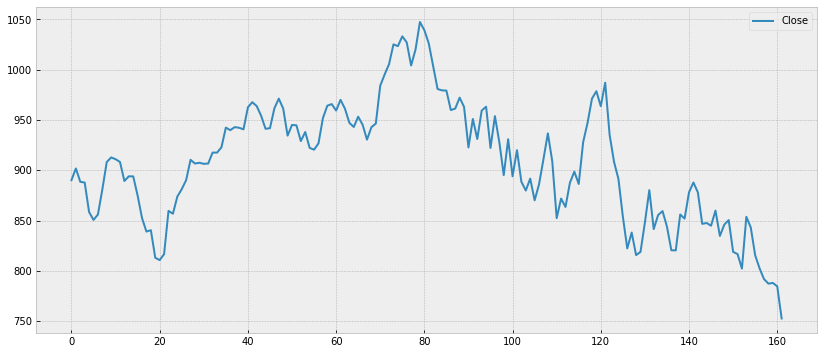

In [3]:
with plt.style.context('bmh'):
    plt.figure(figsize=(14,6))
    plt.plot(series)
    plt.legend()

In [4]:
import statsmodels.tsa.api as smt
import statsmodels.api as sm

In [5]:
def test_stationarity(timeseries):
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for [key, value] in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

In [6]:
def tsplot(y, lags=None, figsize=(14, 8), style='bmh'):
    test_stationarity(y)
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):
        plt.figure(figsize=figsize)
        layout = (5, 1)
        ts_ax = plt.subplot2grid(layout, (0, 0), rowspan=2)
        acf_ax = plt.subplot2grid(layout, (2, 0))
        pacf_ax = plt.subplot2grid(layout, (3, 0))
        qq_ax = plt.subplot2grid(layout, (4, 0))

        y.plot(ax=ts_ax, color='blue', label='Or')
        ts_ax.set_title('Original')

        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)
        sm.qqplot(y, line='s', ax=qq_ax)
        
        plt.tight_layout()
    return

Строим модель ARIMA

In [7]:
import warnings
warnings.filterwarnings("ignore")

def _get_best_model(TS):
    best_aic = np.inf 
    best_order = None
    best_mdl = None

    for i in range(5):
        for d in range(5):
            for j in range(5):
                try:
                    tmp_mdl = smt.ARIMA(TS, order=(i,d,j)).fit(
                        method='mle', trend='nc'
                    )
                    tmp_aic = tmp_mdl.aic
                    if tmp_aic < best_aic:
                        best_aic = tmp_aic
                        best_order = (i, d, j)
                        best_mdl = tmp_mdl
                except: continue
    print('aic: {:6.5f} | order: {}'.format(best_aic, best_order))                    
    return best_aic, best_order, best_mdl

aic, order, mdl = _get_best_model(series)

aic: 1416.27670 | order: (2, 2, 3)


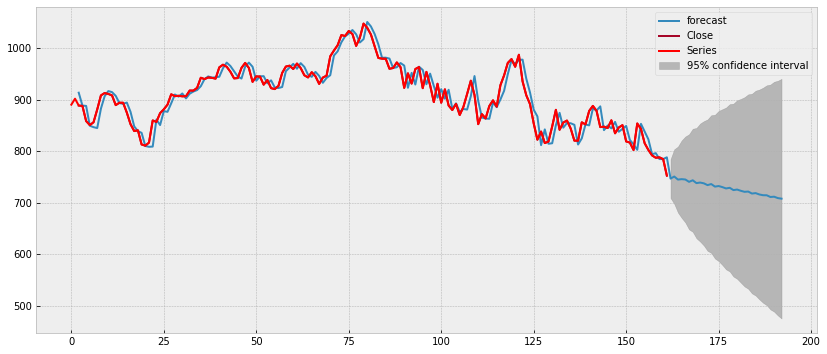

In [8]:
with plt.style.context('bmh'):
    plt.figure(figsize=(14,6))
    ax = plt.axes()
    mdl.plot_predict(2, len(series)+30, ax=ax)
    plt.plot(series, color='red', label='Series')
    plt.legend()
    plt.show()

Строим модель GARCH используя параметры ARIMA

In [9]:
from scipy.stats import boxcox
series = boxcox(series, 0.83)
series = np.diff(series, 1)

In [10]:
from arch import arch_model

In [11]:
p_, o_, q_ = order

am = arch_model(series, p=p_, o=o_, q=q_, dist='StudentsT')
res = am.fit(update_freq=5, disp='off')
print(res.summary())

                      Constant Mean - GJR-GARCH Model Results                       
Dep. Variable:                            y   R-squared:                      -0.001
Mean Model:                   Constant Mean   Adj. R-squared:                 -0.001
Vol Model:                        GJR-GARCH   Log-Likelihood:               -512.485
Distribution:      Standardized Student's t   AIC:                           1044.97
Method:                  Maximum Likelihood   BIC:                           1075.78
                                              No. Observations:                  161
Date:                      Tue, May 21 2019   Df Residuals:                      151
Time:                              15:25:53   Df Model:                           10
                               Mean Model                               
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu            -0

Results of Dickey-Fuller Test:
Test Statistic                -1.302172e+01
p-value                        2.445951e-24
#Lags Used                     0.000000e+00
Number of Observations Used    1.600000e+02
Critical Value (1%)           -3.471896e+00
Critical Value (5%)           -2.879780e+00
Critical Value (10%)          -2.576495e+00
dtype: float64


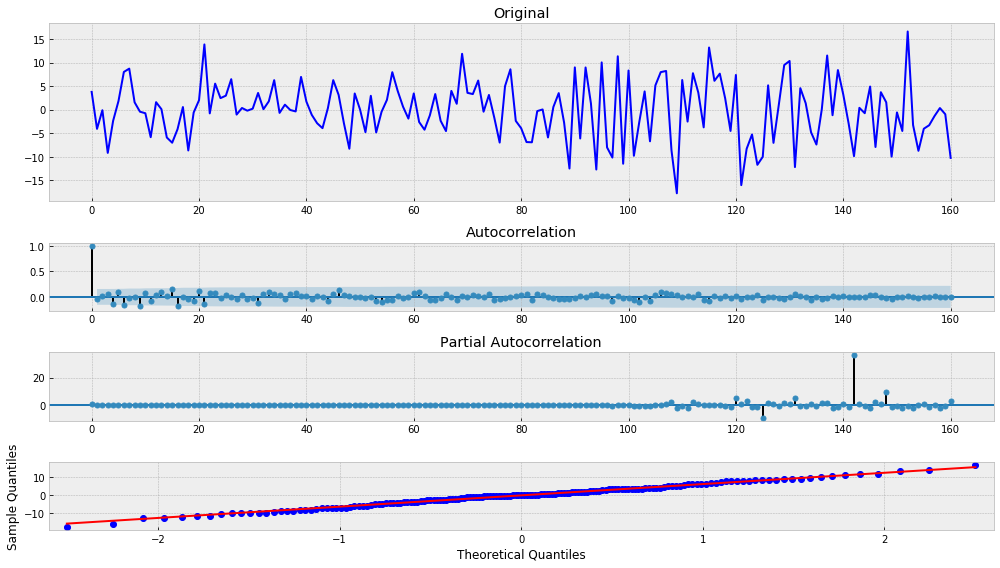

In [12]:
tsplot(res.resid)

## Теперь для прогноза используем классический метод ML

In [13]:
def prepareData(data, lag_start=1, lag_end=20, test_size=0.2):
    
    data = pd.DataFrame(data.copy())
    
    # считаем индекс в датафрейме, после которого начинается тестовый отрезок
    test_index = int(len(data)*(1-test_size))
    
    # добавляем лаги исходного ряда в качестве признаков
    for i in range(lag_start, lag_end):
        data["lag_{}".format(i)] = data.Close.shift(i)
        
    data = data.dropna()
    data = data.reset_index(drop=True)
    data = data.drop(["Week"], axis=1)
     
    # разбиваем весь датасет на тренировочную и тестовую выборку
    X_train = data.loc[:test_index].drop(["Close"], axis=1)
    y_train = data.loc[:test_index]["Close"]
    X_test = data.loc[test_index:].drop(["Close"], axis=1)
    y_test = data.loc[test_index:]["Close"]
    
    return X_train, X_test, y_train, y_test

In [14]:
X_train, X_test, y_train, y_test = prepareData(data, lag_start=1, lag_end=20, test_size=0.3)

In [15]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
rf = RandomForestRegressor()

max_depth = list(range(3, 31, 3))
min_samples_leaf = list(range(5, 31, 5))
params_grid = {'max_depth':max_depth, 'min_samples_leaf':min_samples_leaf}
rf_grid = GridSearchCV(rf, params_grid, cv=5, n_jobs=-1, scoring='neg_mean_squared_error')
rf_grid.fit(X_train, y_train)

C:\ProgramData\Anaconda3_new\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'max_depth': [3, 6, 9, 12, 15, 18, 21, 24, 27, 30], 'min_samples_leaf': [5, 10, 15, 20, 25, 30]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=0)

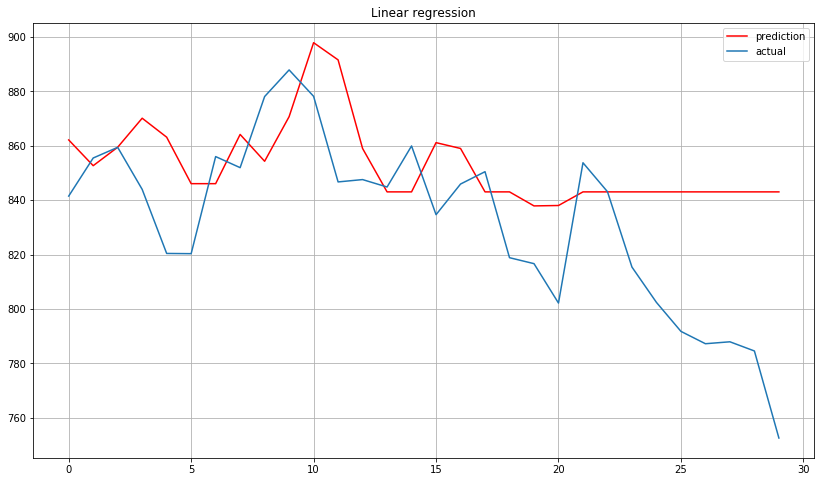

In [16]:
prediction = rf_grid.best_estimator_.predict(X_test)

plt.figure(figsize=(14, 8))
plt.plot(prediction, "r", label="prediction")
plt.plot(y_test.values, label="actual")
plt.legend(loc="best")
plt.title("Linear regression")
plt.grid(True);

Результат получился не очень, попробуем на линейной модели

In [17]:
from sklearn.linear_model import Lasso
lasso_reg = Lasso()

In [18]:
alpha = [1, 0.1, 0.05, 0.01, 0.001]
params_grid = {'alpha': alpha}
lasso_grid = GridSearchCV(lasso_reg, params_grid, cv=5, n_jobs=-1, scoring='neg_mean_squared_error')

In [19]:
lasso_grid.fit(X_train, y_train)

C:\ProgramData\Anaconda3_new\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'alpha': [1, 0.1, 0.05, 0.01, 0.001]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=0)

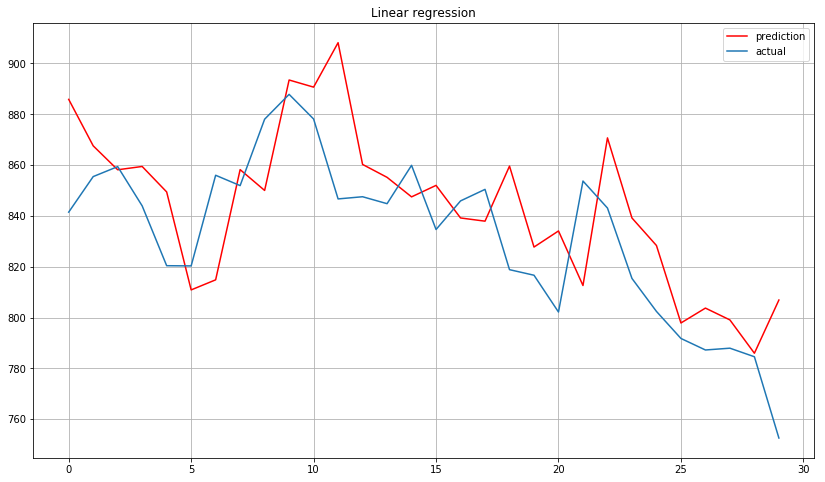

In [20]:
prediction = lasso_grid.best_estimator_.predict(X_test)

plt.figure(figsize=(14, 8))
plt.plot(prediction, "r", label="prediction")
plt.plot(y_test.values, label="actual")
plt.legend(loc="best")
plt.title("Linear regression")
plt.grid(True);

С линейной моделью результат вышел лучше и заодно вспомним как предсказывала наша модель ARIMA

In [27]:
series = data['Close']
aic, order, mdl  = _get_best_model(series[:-29])

aic: 1156.99470 | order: (4, 2, 3)


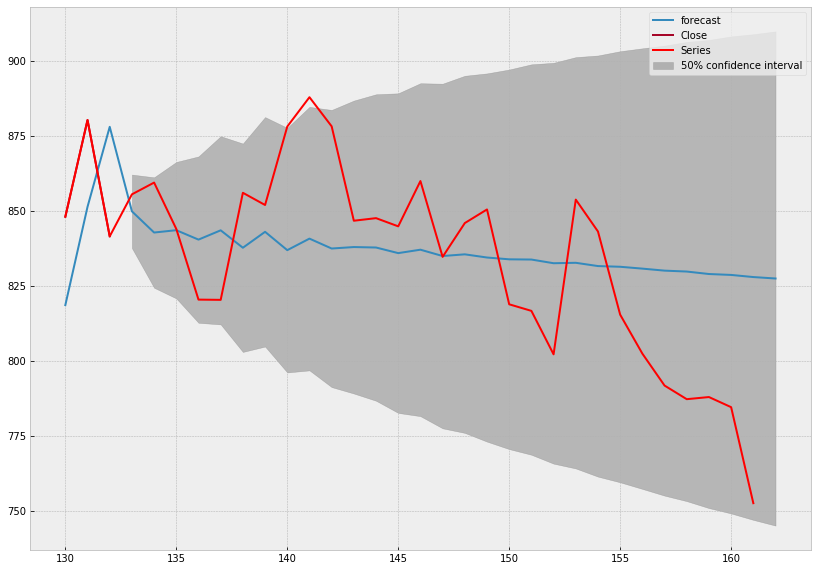

In [28]:
with plt.style.context('bmh'):
    plt.figure(figsize=(14,10))
    ax = plt.axes()
    mdl.plot_predict(start=130, end=len(series), alpha=0.5, ax=ax)
    plt.plot(series[130:], color='red', label='Series')
    plt.legend()
    plt.show()

Видим что у классического ML результат получился лучше